### Layer 1 Subgraph Embedding and Data Exploration Example

In [3]:
import networkx as nx
import pandas as pd
import numpy as np
from node2vec.node2vec import Node2Vec
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
# Extract final node and edge tables below

nodes = pd.read_csv('FINAL_node2vec_results/final_connectome_node_table.csv')
edges = pd.read_csv('FINAL_node2vec_results/final_connectome_edge_table.csv')

In [7]:
def filter_by_layer(nodes, edges, layer):
    '''
    Extract subgraphs from June connectome data by layer for analysis
    Parameters: 
        nodes (Pandas dataframe) final june node dataframe
        edges (Pandas dataframe) final june edge dataframe 
        layer (string) layer of interest to extract
    Return: 
        node table subgraph (Pandas dataframe) by layer
        edge table subgraph (Pandas dataframe) by layer
        Subgraph G (NetworkX graph object)
    '''

    # Filter entire node table to only those in layer 
    rslt_synapse_df = nodes[nodes['layer'] == layer] 
    
    # Get list of unique neurons
    list_of_neurons = set(rslt_synapse_df['pt_root_id'].to_list())

    # Filter the synapse tables  extract all unique connections between nodes
    filtered = edges[edges['Source'].isin(list_of_neurons)]
    filtered2 = filtered[filtered['Target'].isin(list_of_neurons)]

    # create graph object
    G = nx.from_pandas_edgelist(filtered2, source="Source", target="Target", create_using=nx.DiGraph, edge_attr=["Euclidean_Distance"])
    list_of_current_nodes = set(list(G.nodes))
    missing_nodes = list(list_of_current_nodes ^ list_of_neurons)
    G.add_nodes_from(missing_nodes)
    
    return rslt_synapse_df, filtered2, G

In [9]:
node_L1, bedge_L1, G_L1 = filter_by_layer(nodes, edges, 'L1')  # sample run for subgraph L1


# Node2vec graph embedding to R^30  i.e. 30 features 
node2vec_of_G_L1 = Node2Vec(G_L1, dimensions=30, walk_length=45, num_walks=150, p=0.3, q=0.7)

model = node2vec_of_G_L1.fit(window=10, min_count=1, batch_words=4)  
# Any keywords acceptable by gensim.Word2Vec can be passed

# Create dataframe of the node embeddings

node_embedding_dict = {}

list_of_nodes = list(G_L1.nodes)

for i in range(len(list_of_nodes)):
    node = str(list_of_nodes[i])
    vector = model.wv[node]
    node_embedding_dict[node] = vector

df_embeddings = pd.DataFrame.from_dict(node_embedding_dict, orient='index')
df_embeddings

Computing transition probabilities:   0%|          | 0/1288 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 150/150 [00:37<00:00,  3.96it/s]


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
864691136310659479,-0.788358,-2.065027,0.489191,0.961159,1.730448,-2.235807,-1.324870,-1.841300,0.607054,-0.580289,...,-0.477236,-0.259742,-0.230145,-0.752609,-0.161580,1.025619,0.401809,0.328619,-0.606729,-0.989800
864691136004775370,0.501287,-2.786188,0.245829,0.966912,0.109561,-1.517482,-0.676799,-2.377460,0.499430,-1.559712,...,0.063727,-1.508726,-1.246456,-0.664683,-1.435315,1.291645,-0.304810,-1.122212,0.149877,-0.583185
864691136487266578,0.332921,-0.166241,0.707333,0.431156,-0.165243,-0.579247,-0.250691,0.024867,-0.145832,-1.680239,...,-0.003237,-0.889188,-1.173393,-0.230789,0.294892,0.797218,-0.180063,0.201928,-0.580112,-1.201670
864691135354901967,0.380917,-0.129579,0.923925,0.173568,-0.322636,-0.706281,0.022609,0.036075,0.213364,-1.546726,...,-0.105412,-0.536153,-0.959845,-0.407394,0.180394,0.598839,-0.474473,0.721149,-0.619225,-1.314278
864691135682294932,0.403774,-0.537932,0.369968,0.053388,-0.168251,-0.522198,-0.355781,0.118738,-0.166413,-0.737334,...,-0.434639,-0.100018,-0.249791,-0.665651,-0.627440,0.599859,-0.113867,0.067678,-0.166762,-0.479458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
864691136020304376,0.749347,-2.447901,0.194822,0.771935,-0.237846,-1.017133,-0.544989,-2.075911,0.326373,-1.610493,...,0.075153,-1.536641,-1.190987,-0.638609,-1.490466,1.351553,-0.375412,-1.364835,0.070438,-0.300111
864691135367005945,-0.295565,-1.115685,1.499166,1.739227,-1.064962,-1.251371,-1.590373,-0.309584,-0.196945,-0.957744,...,0.049947,-0.557732,-0.063449,-0.310517,-0.579910,1.088795,-0.224474,0.306855,0.298943,0.317380
864691135941602420,0.646331,-2.333468,0.348698,0.747743,-0.139296,-1.001820,-0.636860,-2.081413,0.250662,-1.545226,...,0.215693,-1.595694,-1.298945,-0.667778,-1.364360,1.298908,-0.473775,-1.161420,0.200465,-0.277291
864691135855599918,-0.890055,0.585866,1.090717,0.128691,2.595172,0.171062,-2.322237,-2.580936,-0.148678,-0.882439,...,-0.511927,-1.302717,-1.970176,-2.773950,-1.065455,4.347395,-0.372734,-1.109286,0.154926,-0.048343


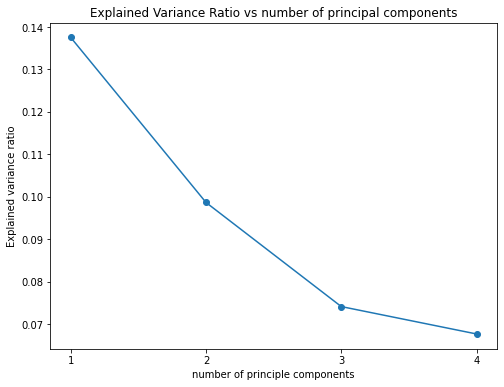

In [10]:
scaler = StandardScaler()

# standardize the data
scaled_df = pd.DataFrame(scaler.fit_transform(df_embeddings), columns = df_embeddings.columns)
scaled_df.head()

# conduct Principle Component Analysis
pca = PCA(n_components=4).fit(scaled_df)

fig_1 = plt.figure(figsize = (8,6), facecolor='w',edgecolor='k')
plt.plot(np.arange(1,5), pca.explained_variance_ratio_,'o-')
plt.title('Explained Variance Ratio vs number of principal components')
plt.xlabel('number of principle components')
plt.ylabel('Explained variance ratio')
plt.xticks([1,2,3,4])
plt.show()

Text(0, 0.5, 'z2')

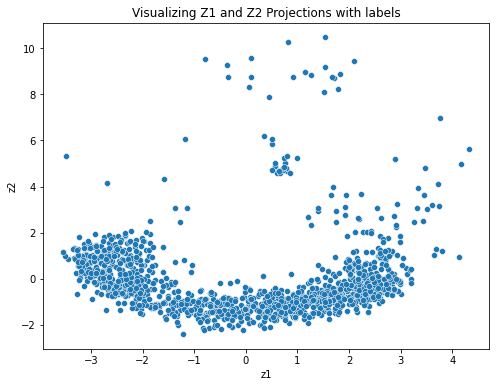

In [11]:
# transform data using 
x = scaler.transform(df_embeddings)

phi1 = pca.components_[0]
phi2 = pca.components_[1]

z1 = pca.transform(scaled_df)[:,0]
z2 = pca.transform(scaled_df)[:,1]

fig_1 = plt.figure(figsize = (8,6), facecolor='w',edgecolor='k')
sns.scatterplot(x = z1,y = z2)
plt.title('Visualizing Z1 and Z2 Projections with labels')
plt.xlabel('z1')
plt.ylabel('z2')

c:\Users\disc2\Desktop\Graph_Analytics_Crimson\myenv\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\disc2\Desktop\Graph_Analytics_Crimson\myenv\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1288 samples in 0.001s...
[t-SNE] Computed neighbors for 1288 samples in 0.085s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1288
[t-SNE] Computed conditional probabilities for sample 1288 / 1288
[t-SNE] Mean sigma: 0.934383
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.783440
[t-SNE] KL divergence after 1000 iterations: 0.955479


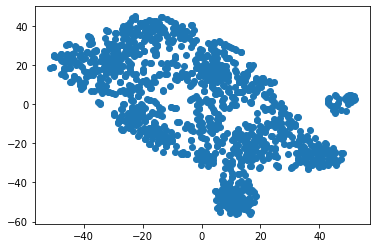

In [13]:
# Implementation of TSNE 2-order viz

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(df_embeddings)
df = pd.DataFrame()
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]
plt.scatter(df["comp-1"], df["comp-2"]) 
plt.show()

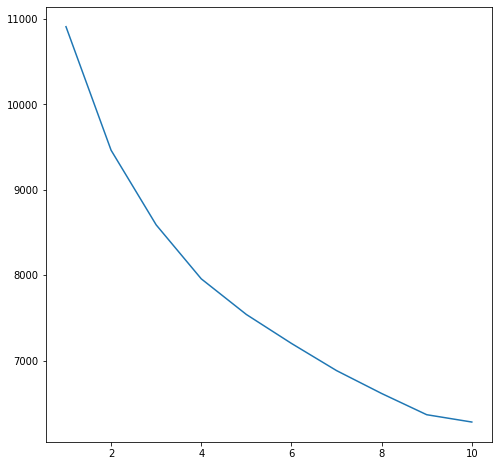

In [14]:
from sklearn.cluster import KMeans

# inertia : model.inertia 
k = [1,2,3,4,5,6,7,8,9,10]
in1 = []
for i in (k):
    model = KMeans(n_clusters = i).fit(df_embeddings)
    in1.append(model.inertia_)
fig_1 = plt.figure(figsize = (8,8), facecolor='w',edgecolor='k')
plt.plot(k,in1)

In [17]:
model = KMeans(n_clusters = 10)
model.fit(df_embeddings)
s = model.score(df_embeddings)
y_pred = model.predict(df_embeddings) 

Text(0, 0.5, 'z2')

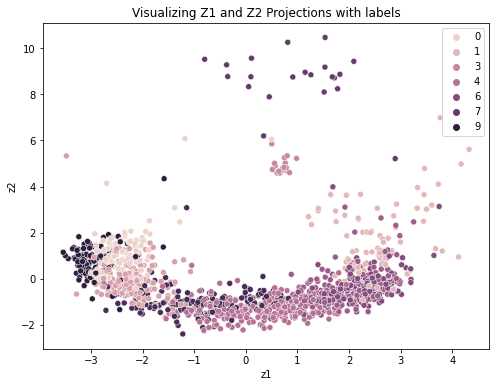

In [18]:
fig_1 = plt.figure(figsize = (8,6), facecolor='w',edgecolor='k')
sns.scatterplot(x = z1,y = z2, hue = y_pred)
plt.title('Visualizing Z1 and Z2 Projections with labels')
plt.xlabel('z1')
plt.ylabel('z2')

From applying kMeans clustering, we can identify k = 10 clusters best explain the variance in the embeddings data. Each extracted cluster may highlight unique properties, relating to the original subgraph (L1). Given the process of node2vec, interpretality of these clusters may be difficult. However, locating the attributes of each of these nodes can help us better understand the clusters formed in this subgraph. 